In [ ]:
import os
import sys
import pickle
import copy
from pathlib import Path

from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FormatStrFormatter
%matplotlib inline

import torchvision

_US8k = 'US8K'
_ESC50 = 'ESC50'
dataset = _ESC50

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)
if 'cuda' not in str(device):
  raise Exception('Notebook did not get GPU resource')

cuda:0


In [ ]:
USE_GOOGLE_COLAB = False
DATASET_PATH = 'Datasets'
RESULT_PATH = 'Results'

if USE_GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    DATASET_PATH = '/content/gdrive/My Drive/' + DATASET_PATH
    RESULT_PATH = '/content/gdrive/My Drive/' + RESULT_PATH


Mounted at /content/gdrive


# Dataset info

In [ ]:
dataset_df = pd.read_pickle(f"{DATASET_PATH}/{dataset}_df.pkl")
INPUT_SIZE = dataset_df.iloc[0]['melspectrogram'].shape
RESHAPE_SIZE = (1, INPUT_SIZE[0], INPUT_SIZE[1])
print(f"Input size: {INPUT_SIZE}")

Input size: (128, 215)


In [ ]:
dataset_df.head()

,melspectrogram,label,text
0,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",0,dog
1,"[[-64.1004017105852, -71.74158103476631, -80.0...",1,chirping_birds
2,"[[-21.924480388829352, -18.98850990817047, -14...",2,vacuum_cleaner
3,"[[-0.23126438201498445, -8.0180314249546, -12....",2,vacuum_cleaner
4,"[[-44.504696485712635, -47.845441045727156, -3...",3,thunderstorm


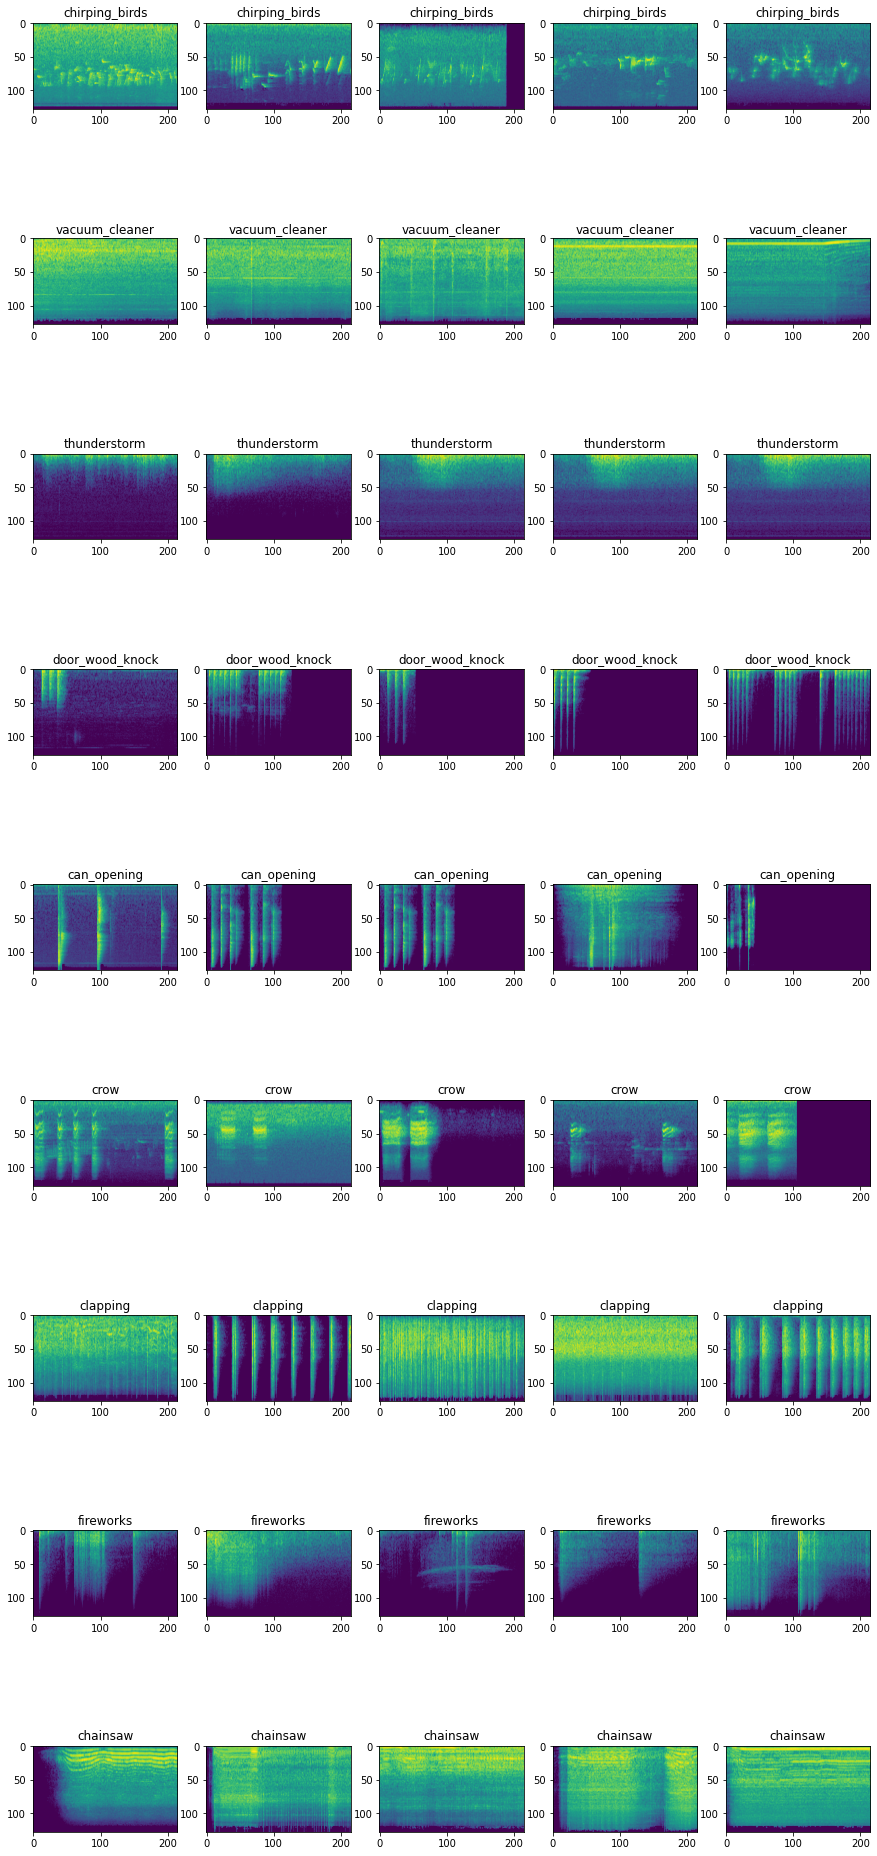

In [ ]:
def plot_image(img, plot_idx, title, row_num=2, col_num=4):
    plt.subplot(row_num,col_num,plot_idx)
    plt.title(title)
    # plt.imshow(img, vmin=0, vmax=100)
    plt.imshow(img)

    return plot_idx + 1

figsize=(15,35)
plt.figure(figsize=figsize)

# Display some of the spectrograms
idx = 1
for i in range(1, 10):
  items = dataset_df[dataset_df.label == i].sample(n=5, replace=True)
  for j in range(len(items)):
    idx = plot_image(items['melspectrogram'].iloc[j].copy(), idx, items['text'].iloc[j], col_num=5, row_num=9)

# Augments

In [ ]:
#@title Custom dataset class { run: "auto" }
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, pair_type='same'):
        assert isinstance(dataframe, pd.DataFrame)
        assert len(dataframe.columns) == 3

        self.dataframe = dataframe
        self.transform = transform
        self.pair_type = pair_type

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image, label, text = self.dataframe.iloc[index]
        images = [image.copy()]
        labels = [label.copy()]

        # print('picking random image')
        # find pair for current image
        while True:
          index_rand = np.random.randint(len(self.dataframe), size=1)[0]
          rand_img, rand_label, _ = self.dataframe.iloc[index_rand]
          if (self.pair_type == 'same' and rand_label == label) or \
            (self.pair_type == 'diff' and rand_label != label):
            images.append(rand_img.copy())
            labels.append(rand_label.copy())
            break
            
        # print('transforming image')
        if self.transform is not None:
            image = self.transform(images)[0]

        return {'spectrogram': image, 'label': label, 'text': text }

In [ ]:
#@title Augmentations
class RightShift(object):
    """Shift the image to the right in time."""

    def __init__(self, width_shift_range, probability=1.0):
        assert isinstance(width_shift_range, (int, float))
        assert isinstance(probability, (float))

        if isinstance(width_shift_range, int):
            assert width_shift_range > 0
            self.width_shift_range = width_shift_range
        else:
            assert width_shift_range > 0.0
            assert width_shift_range <= 1.0
            self.width_shift_range = int(width_shift_range * self.input_size[1])
                        
        assert probability > 0.0 and probability <= 1.0
        self.probability = probability

    def __call__(self, images):
        if np.random.random() > self.probability:
          return images

        image = images[0]
        # create a new array filled with the min value
        shifted_image= np.full(image.shape, np.min(image), dtype='float32')

        # randomly choose a start postion
        rand_position = np.random.randint(1, self.width_shift_range)

        # shift the image
        shifted_image[:,rand_position:] = copy.deepcopy(image[:,:-rand_position])

        images[0] = shifted_image
        return images

class GaussNoise(object):
    """Add Gaussian noise to the spectrogram image."""

    def __init__(self, mean=0.0, std=None, probability=1.0):
        assert isinstance(mean, (int, float))
        assert isinstance(std, (int, float)) or std is None
        assert isinstance(probability, (float))

        self.mean = mean

        if std is not None:
            assert std > 0.0
            self.std = std
        else:
            self.std = std

        assert probability > 0.0 and probability <= 1.0
        self.probability = probability


    def __call__(self, images):
      if np.random.random() > self.probability:
          return images


      image = images[0]
      # print('adding noise')
      # set some std value 
      min_pixel_value = np.min(image)
      if self.std is None:
        std_factor = 0.03     # factor number 
        std = np.abs(min_pixel_value*std_factor)

      # generate a white noise image
      gauss_mask = np.random.normal(self.mean, 
                                    std, 
                                    size=image.shape).astype('float32')
      
      # add white noise to the sound image
      noisy_image = image + gauss_mask
      images[0] = noisy_image

      return images

class Reshape(object):
    """Reshape the image array."""

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))

        self.output_size = output_size

    def __call__(self, images):
      # print(f"reshape from {images[0].shape}")
      images[0] = images[0].reshape(self.output_size)
      return images

# below methods based https://github.com/ceciliaresearch/MixedExample/blob/master/mixed_example.py
class Mixup(object):
    """merge whole images"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 


      for img in images[1:]:
        images[0] = mix_coeff * images[0] + (1 - mix_coeff) * img
      return images

class vert_mixup(object):
    """mixup images vertically"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 
      cut_point = int(len(images[0]) * mix_coeff)

      # images[0] = np.concatenate((images[0][:cut_point,:], images[1][cut_point:,:]),0)

      for img in images[1:]:
        images[0][cut_point:,:] = mix_coeff * images[0][cut_point:,:] + (1 - mix_coeff) * img[cut_point:,:]

      return images

class horiz_mixup(object):
    """mixup images horizontaly"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 
      cut_point = int(len(images[0]) * mix_coeff)

      # images[0] = np.concatenate((images[0][:,:cut_point], images[1][:,cut_point:]),1)

      for img in images[1:]:
        images[0][:,:cut_point] = mix_coeff * images[0][:,:cut_point] + (1 - mix_coeff) * img[:,:cut_point]

      return images

class random_2x2(object):
    """concat images horizontaly"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability
        self.p = p
        self.offset_min = 0.5 * p
        self.offset_max = 1 - self.offset_min

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      (H, W) = images[0].shape

      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min
      h_cutpoint = int(H * (np.random.random() * (self.offset_max - self.offset_min) + self.offset_min))
      w_cutpoint = int(W * (np.random.random() * (self.offset_max - self.offset_min) + self.offset_min))
      rand_idxs = np.random.randint(0, len(images), 4)

      images[0][:h_cutpoint,:w_cutpoint] = mix_coeff * images[0][:h_cutpoint,:w_cutpoint] + \
        (1 - mix_coeff) * images[rand_idxs[0]][:h_cutpoint,:w_cutpoint] # top left
      images[0][:h_cutpoint,w_cutpoint:] = mix_coeff * images[0][:h_cutpoint,w_cutpoint:] + \
        (1 - mix_coeff) * images[rand_idxs[1]][:h_cutpoint,w_cutpoint:] # top right
      images[0][h_cutpoint:,:w_cutpoint] = mix_coeff * images[0][h_cutpoint:,:w_cutpoint] + \
        (1 - mix_coeff) * images[rand_idxs[2]][h_cutpoint:,:w_cutpoint] # bot left
      images[0][h_cutpoint:,w_cutpoint:] = mix_coeff * images[0][h_cutpoint:,w_cutpoint:] + \
        (1 - mix_coeff) * images[rand_idxs[3]][h_cutpoint:,w_cutpoint:] # bot right
        

      return images

class random_column_interval(object):
    """mixup one image column region"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      (H, W) = images[0].shape
      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 
      idx1 = np.random.randint(0, W)
      idx2 = np.random.randint(idx1, W)

      for img in images[1:]:
        images[0][:,idx1:idx2] = mix_coeff * images[0][:,idx1:idx2] + (1 - mix_coeff) * img[:,idx1:idx2]

      return images

class random_row_interval(object):
    """mixup one image row region"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      (H, W) = images[0].shape
      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 
      idx1 = np.random.randint(0, H)
      idx2 = np.random.randint(idx1, H)


      for img in images[1:]:
        images[0][idx1:idx2,:] = mix_coeff * images[0][idx1:idx2,:] + (1 - mix_coeff) * img[idx1:idx2,:]

      return images

class random_cols(object):
    """mixup random image cols"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability
        self.p = p

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      (H, W) = images[0].shape
      idxs = np.random.choice([0, 1], size=W, p=[1-self.p, self.p])
      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min 
      
      for img in images[1:]:
        images[0] = (1-idxs) * images[0] + idxs * mix_coeff * images[0] + idxs * (1 - mix_coeff) * img

      return images

class random_rows(object):
    """mixup random image rows"""

    def __init__(self, mixup_min=0.4, mixup_max=0.6, p=0.5, probability=1.0):
        assert isinstance(mixup_min, (float))
        assert isinstance(mixup_max, (float))

        self.mixup_min = mixup_min
        self.mixup_max = mixup_max
        self.probability = probability
        self.p = p

    def __call__(self, images):
      if np.random.random() > self.probability:
        return images

      (H, W) = images[0].shape
      idxs = np.random.choice([0, 1], size=H, p=[1-self.p, self.p])
      # idxs = np.ones(W, dtype=float) * idxs
      mix_coeff = np.random.random() * (self.mixup_max - self.mixup_min) + self.mixup_min
      # print(idxs)

      for img in images[1:]:
        orig_img_T = np.transpose(images[0])
        images[0] = np.transpose((1-idxs) * orig_img_T + idxs * mix_coeff * orig_img_T + idxs * (1 - mix_coeff) * np.transpose(img))

      return images


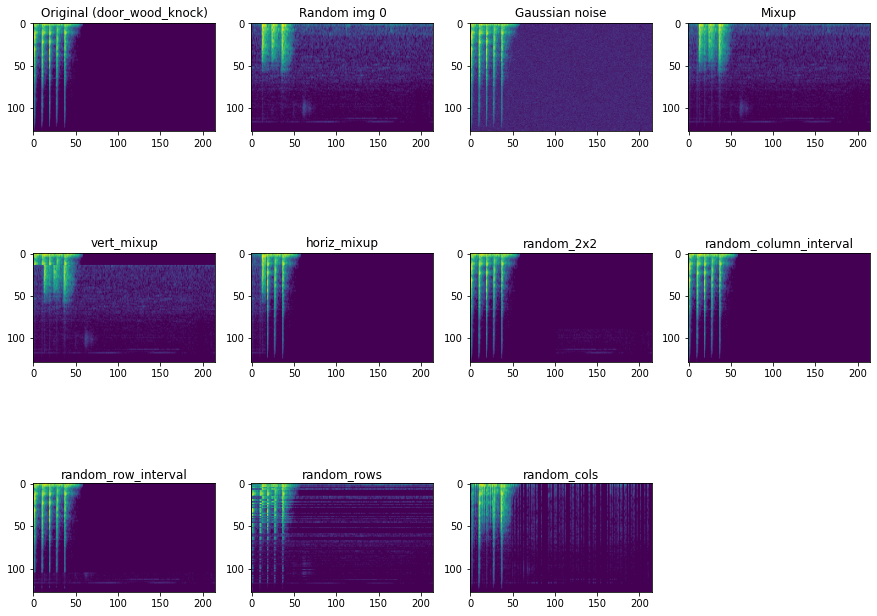

In [ ]:
#@title Augmentation display 1 { run: "auto" }

test_pair_type = 'same'
org_img_index = 9 #@param {type:"number"}
subplot_idx = 1
r = 3
c = 4
a_min = 0.1 #@param {type:"number"}
a_max = 0.2 #@param {type:"number"}
figure_w = 15 #@param {type:"number"}
figure_h = 12 #@param {type:"number"}
img = dataset_df.iloc[org_img_index]['melspectrogram'].copy()
images = [img]
label = dataset_df.iloc[org_img_index]['label']
label_text = dataset_df.iloc[org_img_index]['text']
while True: # pick random image pair
  index_rand = np.random.randint(len(dataset_df), size=1)[0]
  rand_img, rand_label, _ = dataset_df.iloc[index_rand].copy()
  if (test_pair_type == 'same' and rand_label == label) or \
    (test_pair_type == 'diff' and rand_label != label):
    images.append(rand_img)
    break

plt.figure(figsize=(figure_w,figure_h))

subplot_idx = plot_image(img, subplot_idx, f'Original ({label_text})', row_num=r, col_num=c)
for i, img in enumerate(images[1:]):
  subplot_idx = plot_image(img, subplot_idx, f"Random img {i}", row_num=r, col_num=c)

img_aug = GaussNoise(probability=1.0)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'Gaussian noise', row_num=r, col_num=c)

img_aug = Mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'Mixup', row_num=r, col_num=c)

img_aug = vert_mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'vert_mixup', row_num=r, col_num=c)

img_aug = horiz_mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'horiz_mixup', row_num=r, col_num=c)

img_aug = random_2x2(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_2x2', row_num=r, col_num=c)

img_aug = random_column_interval(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_column_interval', row_num=r, col_num=c)

img_aug = random_row_interval(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_row_interval', row_num=r, col_num=c)

img_aug = random_rows(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_rows', row_num=r, col_num=c)

img_aug = random_cols(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_cols', row_num=r, col_num=c)

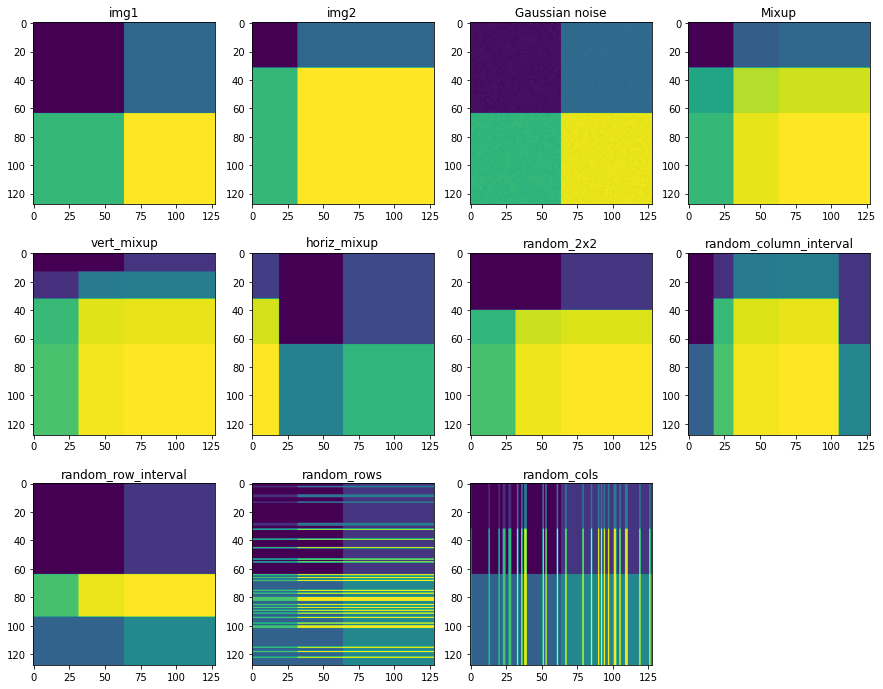

In [ ]:
#@title Augmentation display 2 { run: "auto" }

a_min = 0.1 #@param {type:"number"}
a_max = 0.2 #@param {type:"number"}

img_size = 128
w1 = 32 #@param {type:"number"}
h1 = 32 #@param {type:"number"}
w2 = img_size - w1
h2 = img_size - h1

w3 = 64
h3 = 64

img1 = np.concatenate([
    np.concatenate([np.ones((w3,h3), dtype=np.float32)*32, 
                    np.ones((w3,h3), dtype=np.float32)*64], axis=1),
    np.concatenate([np.ones((w3,h3), dtype=np.float32)*96, 
                    np.ones((w3,h3), dtype=np.float32)*128], axis=1)
], axis=0)

img2 = np.concatenate([
    np.concatenate([np.ones((w1,h1), dtype=np.float32)*64, 
                    np.ones((w1,h2), dtype=np.float32)*128], axis=1),
    np.concatenate([np.ones((w2,h1), dtype=np.float32)*192, 
                    np.ones((w2,h2), dtype=np.float32)*256], axis=1)
], axis=0)

figsize=(15,12)
plt.figure(figsize=figsize)
subplot_idx = 1
images = [np.copy(img1), np.copy(img2)]
subplot_idx = plot_image(images[0], subplot_idx, 'img1', row_num=r, col_num=c)
subplot_idx = plot_image(images[1], subplot_idx, 'img2', row_num=r, col_num=c)


img_aug = GaussNoise(probability=1.0)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'Gaussian noise', row_num=r, col_num=c)

img_aug = Mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'Mixup', row_num=r, col_num=c)

img_aug = vert_mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'vert_mixup', row_num=r, col_num=c)

img_aug = horiz_mixup(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'horiz_mixup', row_num=r, col_num=c)

img_aug = random_2x2(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_2x2', row_num=r, col_num=c)

img_aug = random_column_interval(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_column_interval', row_num=r, col_num=c)

img_aug = random_row_interval(probability=1.0, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_row_interval', row_num=r, col_num=c)

img_aug = random_rows(probability=1.0, p=0.25, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_rows', row_num=r, col_num=c)

img_aug = random_cols(probability=1.0, p=0.25, mixup_min=a_min, mixup_max=a_max)([i.copy() for i in images])[0]
subplot_idx = plot_image(img_aug, subplot_idx, 'random_cols', row_num=r, col_num=c)

# Dataset helper functions

In [ ]:
def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_folds = train_df['text'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels, train_folds), columns=['melspectrogram', 'label', 'text'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_folds = test_df['text'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels, test_folds), columns=['melspectrogram', 'label', 'text'])

    return train_df, test_df

def init_dataloader(train_df, test_df, train_transforms, test_transforms, batch_size=16):
  train_ds = CustomDataset(train_df, transform=train_transforms)
  test_ds = CustomDataset(test_df, transform=test_transforms)
  train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(test_ds, batch_size = batch_size, shuffle = False)
  
  return train_loader, test_loader

{'spectrogram': array([[[-1.807679  , -1.807679  , -1.807679  , ..., -0.20444468,
         -0.1825465 , -0.19869354],
        [-1.807679  , -1.807679  , -1.807679  , ..., -0.35531616,
          0.01007048, -0.26891574],
        [-1.807679  , -1.807679  , -1.807679  , ..., -0.555571  ,
          0.08380286, -0.34928852],
        ...,
        [-1.807679  , -1.807679  , -1.807679  , ..., -0.2434975 ,
         -0.24144147, -0.24057202],
        [-1.807679  , -1.807679  , -1.807679  , ..., -0.18896317,
         -0.19130905, -0.18428908],
        [-1.807679  , -1.807679  , -1.807679  , ..., -0.17036654,
         -0.170705  , -0.1630048 ]]], dtype=float32), 'label': 14, 'text': 'sheep'}


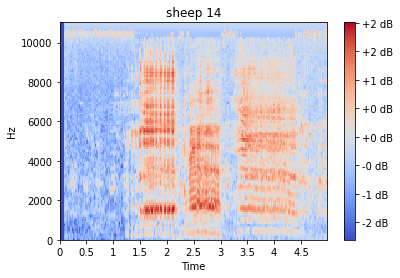

In [ ]:
# split the data
train_df, test_df = train_test_split(dataset_df, test_size=0.25, random_state=42)

# normalize the data
train_df, test_df = normalize_data(train_df, test_df)

# build transformation pipelines for data augmentation
train_transforms = transforms.Compose([RightShift(width_shift_range=13, 
                                                    probability=0.9),
                                       GaussNoise(probability=0.55),
                                       Reshape(output_size=RESHAPE_SIZE)])

test_transforms = transforms.Compose([Reshape(output_size=RESHAPE_SIZE)])

# init train data loader
train_ds = CustomDataset(train_df, transform=train_transforms)
iterator = iter(train_ds)
item = next(iterator)
print(item)
# plt.imshow(item['spectrogram'].reshape((128,128)))
mel_sample = item['spectrogram']
sample_label = item['text']
sample_label_int = item['label']

import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_sample.reshape(INPUT_SIZE), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=f"{sample_label} {sample_label_int}")
fig.colorbar(img, ax=ax, format="%+2.f dB")

# Training setup

In [ ]:
def lr_decay(optimizer, epoch, learning_rate):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer.param_groups[0]['lr'] = new_lr
    print(f'Changed learning rate to {new_lr}')
  return optimizer


def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, lr, change_lr=None):
  train_losses = []
  valid_losses = []
  train_accuracy = []
  valid_accuracy = []

  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    trace_y = []
    trace_yhat = []

    if change_lr:
      optimizer = change_lr(optimizer, epoch, lr)

    for i, data in enumerate(train_loader):
      x = data['spectrogram'].to(device)
      y = data['label'].to(device)
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())

    train_losses.append(np.mean(batch_losses))

    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    train_accuracy.append(np.mean(accuracy))
    #print(f'Epoch - {epoch} Train-Loss : {np.mean(batch_losses)}')

    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []

    for i, data in enumerate(valid_loader):
      x = data['spectrogram'].to(device)
      y = data['label'].to(device)
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())

    valid_losses.append(np.mean(batch_losses))

    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    valid_accuracy.append(accuracy)
    #print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
  return model, train_losses, valid_losses, train_accuracy, valid_accuracy


### Setting up desired augment array

In [ ]:
a_min=0.7
a_max=0.8
train_transform_names = []
train_transform_sets = []
prob = 0.3

# train_transform_names.append('No augmentation')
# train_transform_sets.append(transforms.Compose([
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Mixup {a_min}-{a_max} prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   Mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Vert. mixup {a_min}-{a_max} prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   vert_mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Horiz. mixup {a_min}-{a_max} prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   horiz_mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Gaussian noise prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   GaussNoise(probability=prob),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Random 2x2 mixup {a_min}-{a_max} prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   random_2x2(probability=prob, mixup_min=a_min, mixup_max=a_max),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

# train_transform_names.append(f"Random column interval mixup {a_min}-{a_max} prob={prob}")
# train_transform_sets.append(transforms.Compose([
#   random_column_interval(probability=prob, mixup_min=a_min, mixup_max=a_max),
#   Reshape(output_size=RESHAPE_SIZE),
# ]))

train_transform_names.append(f"Random row interval mixup {a_min}-{a_max} prob={prob}")
train_transform_sets.append(transforms.Compose([
  random_row_interval(probability=prob, mixup_min=a_min, mixup_max=a_max),
  Reshape(output_size=RESHAPE_SIZE),
]))

train_transform_names.append(f"Random rows mixup {a_min}-{a_max} prob={prob}")
train_transform_sets.append(transforms.Compose([
  random_rows(probability=prob, mixup_min=a_min, mixup_max=a_max),
  Reshape(output_size=RESHAPE_SIZE),
]))

train_transform_names.append(f"Random cols mixup {a_min}-{a_max} prob={prob}")
train_transform_sets.append(transforms.Compose([
  random_cols(probability=prob, mixup_min=a_min, mixup_max=a_max),
  Reshape(output_size=RESHAPE_SIZE),
]))

# RightShift(width_shift_range=13, probability=prob),
# GaussNoise(probability=prob),
# Mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
# vert_mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
# horiz_mixup(probability=prob, mixup_min=a_min, mixup_max=a_max),
# random_2x2(probability=prob, mixup_min=a_min, mixup_max=a_max),
# random_column_interval(probability=prob, mixup_min=a_min, mixup_max=a_max),
# random_row_interval(probability=prob, mixup_min=a_min, mixup_max=a_max),
# random_rows(probability=prob, mixup_min=a_min, mixup_max=a_max)
# random_cols(probability=prob, mixup_min=a_min, mixup_max=a_max)

test_transforms = transforms.Compose([Reshape(output_size=RESHAPE_SIZE)])

In [ ]:
# loop over different augment sets
for config_name, train_transforms in zip(train_transform_names, train_transform_sets):
  print(f"Starting training with '{config_name}'")
  print(train_transforms)

Starting training with 'Random row interval mixup 0.7-0.8 prob=0.3'
Compose(
)
Starting training with 'Random rows mixup 0.7-0.8 prob=0.3'
Compose(
)
Starting training with 'Random cols mixup 0.7-0.8 prob=0.3'
Compose(
)


### Training model separately using defined augments

In [ ]:
def get_confusion_matrix(model, label_names, data_loader):
    y_pred = []
    y_true = []
    if torch.cuda.is_available():
      device=torch.device('cuda:0')
    else:
      device=torch.device('cpu')
    model.eval()
    # don't calculate gradient
    with torch.no_grad():
      for i, data in enumerate(data_loader):
        x = data['spectrogram'].to(device)
        y = data['label'].to(device)
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.long)
        y_hat = model(x)

        y_true.extend(y.cpu().detach().numpy())
        y_pred.extend(np.argmax(y_hat.cpu().detach().numpy(),1))      


    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix, index = [name for name in label_names], columns =  [name for name in label_names])
    df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)
    
    return df_cm

# Training

In [ ]:
y = [0.7, 0.85, 0.925, 0.955, 0.96, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969, 0.969]
y2 = [0.8, 0.9, 0.93, 0.96, 0.97, 0.98, 0.99, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999]

# summarize history for accuracy
# epochs = 25
# fig, ax = plt.subplots(1,2,figsize=(12, 4))
# ax[0].set_xlim(0, epochs)
# ax[0].set_ylim(0.7, 1)
# ax[0].plot(train_accuracy)
# ax[0].plot(valid_accuracy)
# ax[0].title.set_text('model accuracy')
# ax[0].set_ylabel('accuracy')
# ax[0].set_xlabel('epoch')
# ax[0].legend(['Train', 'Validation'], loc='lower right')
# ax[0].grid(b=True, which='major', color='0.3', linestyle='-')
# ax[0].grid(which='minor', color='0.65', linestyle='--')
# ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
# ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[0].yaxis.set_minor_formatter(FormatStrFormatter('%.3f'))

# ax[1].set_xlim(0, epochs)
# ax[1].set_ylim(0.0, 1.5)
# ax[1].plot(train_losses)
# ax[1].plot(valid_losses)
# ax[1].title.set_text('model loss')
# ax[1].set_ylabel('loss')
# ax[1].set_xlabel('epoch')
# ax[1].legend(['Train', 'Validation'], loc='upper right')
# ax[1].grid(b=True, which='major', color='0.3', linestyle='-')
# ax[1].grid(which='minor', color='0.65', linestyle='--')
# ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
# ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))
# plt.show()

Starting training using prob=0.3 a_min=0.7 a_max=0.8 for 25 epochs
creating path '/content/gdrive/My Drive/Results/ESC50_prob=0.3_a-min=0.7_a-max=0.8_epochs=25'

Training using config 'Random row interval mixup 0.7-0.8 prob=0.3'
Using augments: Compose(
)
Model training run: 0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

 36%|███▌      | 9/25 [02:36<04:21, 16.37s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:17<01:36, 16.05s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:52<00:00, 16.51s/it]


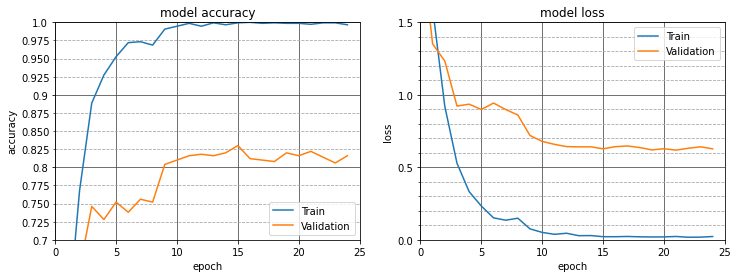

Model training run: 1


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▌      | 9/25 [02:25<04:18, 16.15s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:06<01:36, 16.11s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:44<00:00, 16.19s/it]


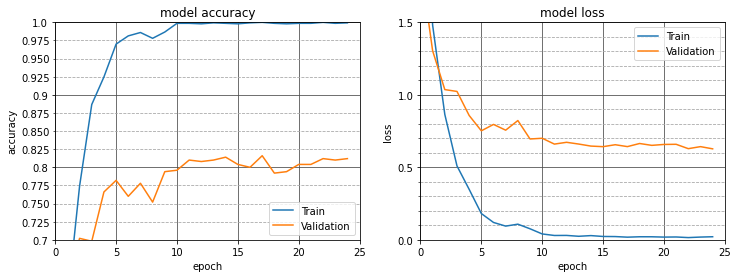

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model training run: 2


 36%|███▌      | 9/25 [02:26<04:20, 16.29s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:06<01:35, 15.95s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:45<00:00, 16.21s/it]


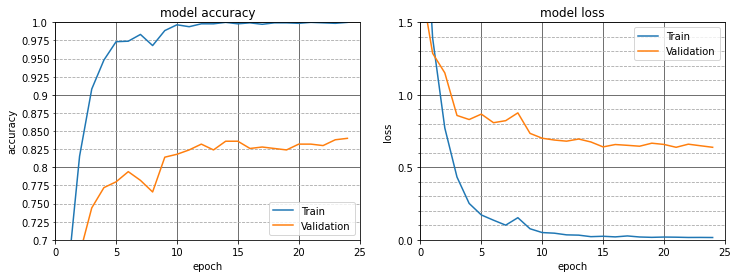

[{'config_name': 'Random row interval mixup 0.7-0.8 prob=0.3', 'train_loss': 0.016236857772005578, 'train_acc': 1.0, 'valid_loss': 0.628113479896759, 'valid_acc': 0.8286666666666666}]
Training using config 'Random rows mixup 0.7-0.8 prob=0.3'
Using augments: Compose(
)
Model training run: 0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▌      | 9/25 [02:24<04:16, 16.05s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:06<01:35, 15.96s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:43<00:00, 16.16s/it]


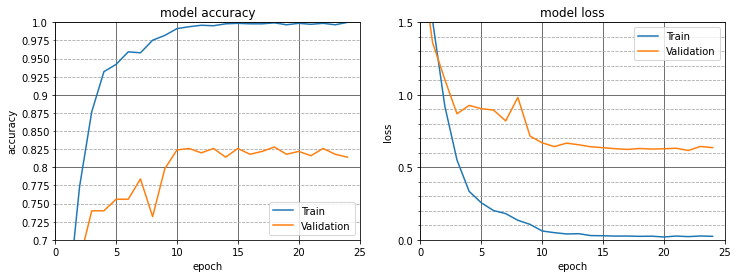

Model training run: 1


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▌      | 9/25 [02:27<04:20, 16.30s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:10<01:37, 16.17s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:46<00:00, 16.26s/it]


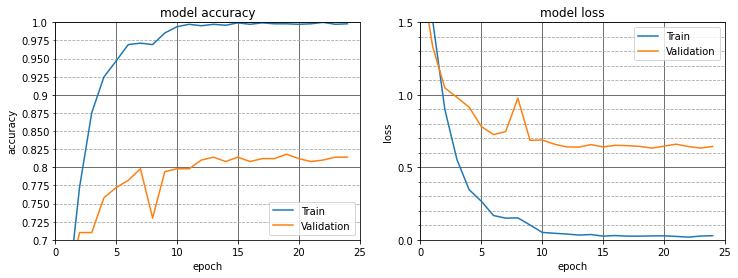

Model training run: 2


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▌      | 9/25 [02:26<04:21, 16.34s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:09<01:38, 16.37s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:46<00:00, 16.25s/it]


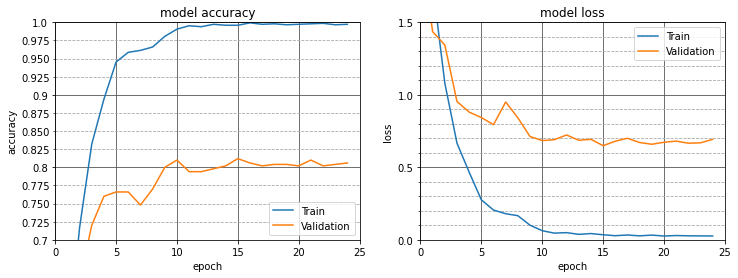

[{'config_name': 'Random row interval mixup 0.7-0.8 prob=0.3', 'train_loss': 0.016236857772005578, 'train_acc': 1.0, 'valid_loss': 0.628113479896759, 'valid_acc': 0.8286666666666666}, {'config_name': 'Random rows mixup 0.7-0.8 prob=0.3', 'train_loss': 0.021215012967454414, 'train_acc': 0.9997777777777778, 'valid_loss': 0.6327190171771994, 'valid_acc': 0.8193333333333334}]
Training using config 'Random cols mixup 0.7-0.8 prob=0.3'
Using augments: Compose(
)
Model training run: 0


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 36%|███▌      | 9/25 [02:26<04:22, 16.42s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:08<01:37, 16.20s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:46<00:00, 16.25s/it]


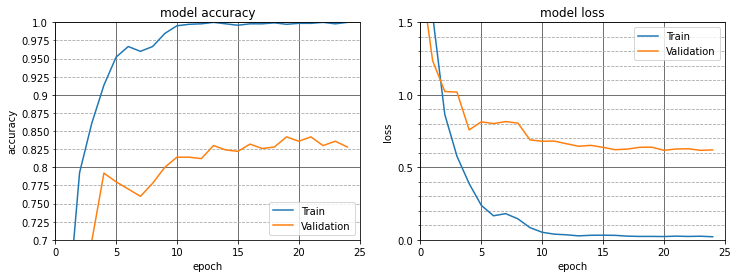

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model training run: 1


 36%|███▌      | 9/25 [02:27<04:23, 16.47s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:10<01:38, 16.37s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:47<00:00, 16.29s/it]


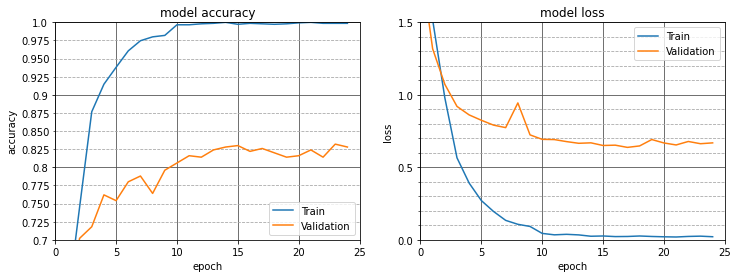

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model training run: 2


 36%|███▌      | 9/25 [02:26<04:18, 16.17s/it]

Changed learning rate to 2e-05


 76%|███████▌  | 19/25 [05:07<01:38, 16.46s/it]

Changed learning rate to 2e-06


100%|██████████| 25/25 [06:45<00:00, 16.20s/it]


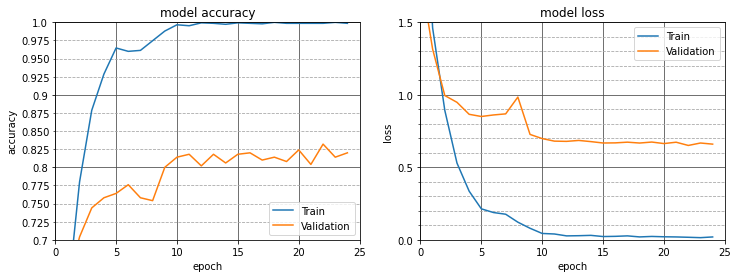

[{'config_name': 'Random row interval mixup 0.7-0.8 prob=0.3', 'train_loss': 0.016236857772005578, 'train_acc': 1.0, 'valid_loss': 0.628113479896759, 'valid_acc': 0.8286666666666666}, {'config_name': 'Random rows mixup 0.7-0.8 prob=0.3', 'train_loss': 0.021215012967454414, 'train_acc': 0.9997777777777778, 'valid_loss': 0.6327190171771994, 'valid_acc': 0.8193333333333334}, {'config_name': 'Random cols mixup 0.7-0.8 prob=0.3', 'train_loss': 0.01841922159924284, 'train_acc': 1.0, 'valid_loss': 0.6351973025205856, 'valid_acc': 0.8353333333333333}]


In [ ]:
run_count = 3
epochs = 25

classes = dataset_df.text.unique()
trained_models_results = []

train_path = f"{dataset}_prob={prob}_a-min={a_min}_a-max={a_max}_epochs={epochs}"
print(f"Starting training using prob={prob} a_min={a_min} a_max={a_max} for {epochs} epochs")
print(f"creating path '{RESULT_PATH}/{train_path}'\n")
Path(f"{RESULT_PATH}/{train_path}").mkdir(parents=True, exist_ok=True)
os.chdir(f"{RESULT_PATH}/{train_path}")


#loop over different augment sets
for config_name, train_transforms in zip(train_transform_names, train_transform_sets):
  print(f"Training using config '{config_name}'")
  #train multiple times
  print(f"Using augments: {train_transforms}")
  train_loader, test_loader = init_dataloader(train_df, test_df, train_transforms, test_transforms, batch_size=16)
  model_result = {
    "config_name": config_name,
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
  }
  for i_run in range(run_count):
    print(f"Model training run: {i_run}")
    learning_rate = 2e-4

    #model = init_model()
    model = None
    net = None
    torch.cuda.empty_cache()
    
    model = models.resnet18(weights=torchvision.models.ResNet18_Weights)
    model.conv1=nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size[0], stride=model.conv1.stride[0], padding=model.conv1.padding[0])
    model.fc = nn.Sequential(*[nn.Dropout(p=0.3), nn.Linear(model.fc.in_features, len(classes))])
    net = model.to(device)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    trained_model, train_losses, valid_losses, train_accuracy, valid_accuracy = train(net, loss_fn, train_loader, test_loader, epochs, optimizer, learning_rate, lr_decay)

    model_result["train_loss"].append(min(train_losses))
    model_result["train_acc"].append(max(train_accuracy))
    model_result["valid_loss"].append(min(valid_losses))
    model_result["valid_acc"].append(max(valid_accuracy))

    # # summarize history for accuracy
    # plt.plot(train_accuracy)
    # plt.plot(valid_accuracy)
    # plt.title('model accuracy')
    # plt.ylabel('accuracy')
    # plt.xlabel('epoch')
    # plt.legend(['Train', 'Validation'], loc='upper left')
    # plt.show()
    # # summarize history for loss
    # plt.plot(train_losses)
    # plt.plot(valid_losses)
    # plt.title('model loss')
    # plt.ylabel('loss')
    # plt.xlabel('epoch')
    # plt.legend(['Train', 'Validation'], loc='upper left')
    # plt.show()

    # summarize history for accuracy
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    ax[0].set_xlim(0, epochs)
    ax[0].set_ylim(0.7, 1)
    ax[0].plot(train_accuracy)
    ax[0].plot(valid_accuracy)
    ax[0].title.set_text('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    ax[0].grid(b=True, which='major', color='0.3', linestyle='-')
    ax[0].grid(which='minor', color='0.65', linestyle='--')
    ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
    ax[0].yaxis.set_minor_formatter(FormatStrFormatter('%.3f'))

    # summarize history for loss
    ax[1].set_xlim(0, epochs)
    ax[1].set_ylim(0.0, 1.5)
    ax[1].plot(train_losses)
    ax[1].plot(valid_losses)
    ax[1].title.set_text('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    ax[1].grid(b=True, which='major', color='0.3', linestyle='-')
    ax[1].grid(which='minor', color='0.65', linestyle='--')
    ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
    ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.show()

    df_cm = get_confusion_matrix(trained_model, classes, test_loader)
    df_cm.to_csv(f"cm_{config_name}_{i_run}.csv")

  # append model results
  model_result["train_loss"] = np.mean(model_result["train_loss"])
  model_result["train_acc"] = np.mean(model_result["train_acc"])
  model_result["valid_loss"] = np.mean(model_result["valid_loss"])
  model_result["valid_acc"] = np.mean(model_result["valid_acc"])
  trained_models_results.append(model_result)
  df = pd.DataFrame(trained_models_results)
  df.to_csv("results.csv")
  print(trained_models_results)


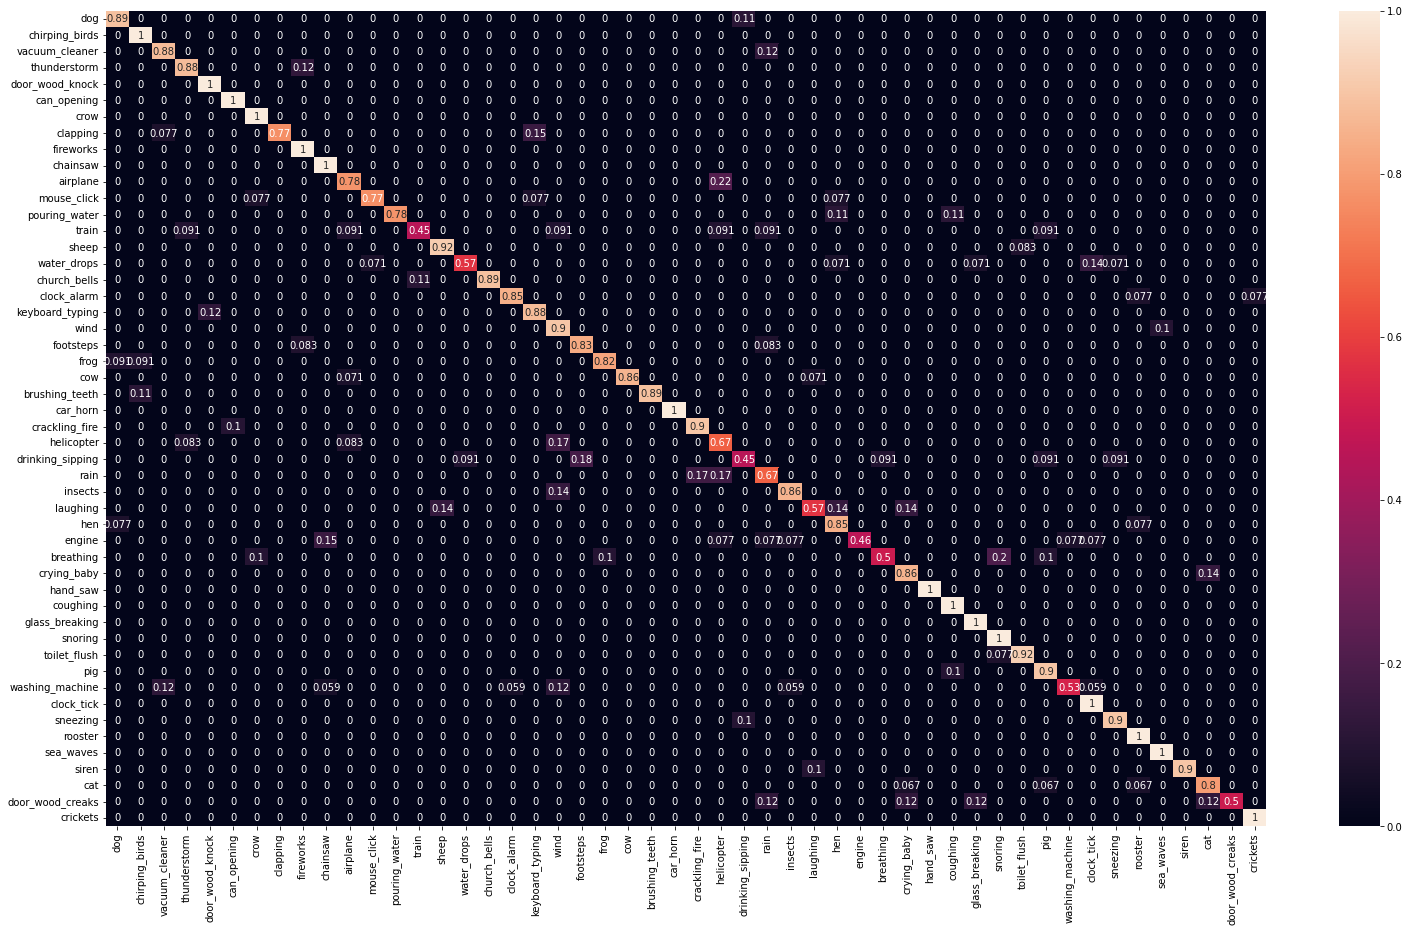

In [ ]:
df_cm = get_confusion_matrix(trained_model, classes, test_loader)
plt.figure(figsize = (26,15))
sns.heatmap(df_cm, annot=True)

In [ ]:
df_cm = get_confusion_matrix(trained_model, classes, test_loader)
df_cm.to_csv("cm.csv")
# files.download("cm.csv")